# Data Processing for Knowledge Graphs

In the notebook, we look to apply the data extraction techniques from elsewhere towards something that can be visualised. Previous outputs show mulitple ways to extract keywords / nouns, with ways to link them based on verb, preposition and other relationships. We can build out a large graph over an entire corpus or datasets and filter by categories, dates, etc. to explore changes in relationships. Fundamentally in a graph, Node A and Node B will represent two different entities. These nodes are connected by an edge that represents the relationship between the two nodes. One obvious example of this on text information is **subject-verb-object**.

In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

import numpy as np
from spacy.matcher import Matcher 
from spacy.tokens import Span

**Import networkx, the package from which we will use to build our graphs.**

In [2]:
import networkx as nx

In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
root_folder = '/content/drive/My Drive/Colab Notebooks'

**Import other files, text_cleaner and contractions as explained in other notebooks.**

In [7]:
import sys
sys.path.append(root_folder)

In [8]:
import Contractions
from Contractions import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
source_folder='/content/drive/My Drive/DataAnalysis'

In [10]:
data = pd.read_csv(source_folder+'/Transcripts_test.csv')
data['date'] = pd.Series(pd.to_datetime(data['date'], format='%m-%d-%y'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   particip    1058 non-null   object        
 1   qna         1058 non-null   int64         
 2   transcript  1058 non-null   object        
 3   date        1058 non-null   datetime64[ns]
 4   company     1058 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 41.5+ KB


In [11]:
def clean(text):
    text = re.sub('[0-9]+.\t', '', str(text)) # removing paragraph numbers
    text = re.sub('U.S.', 'USA', str(text))
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(' ')])
    text = re.sub('\n ', '', str(text))
    text = re.sub('\n', ' ', str(text))
    text = re.sub("'s", '', str(text))
    text = re.sub("-", ' ', str(text))
    text = re.sub("— ", '', str(text))
    text = re.sub('\"', '', str(text))
    text = re.sub("Mr\.", 'Mr', str(text))
    text = re.sub("Mrs\.", 'Mrs', str(text))
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))

    return text

In [12]:
# Light cleaning
data['Transcript_clean'] = data['transcript'].apply(clean)
data = data[data['qna'] == 0]
data = data.drop(['particip'], axis=1)

In [13]:
data

,qna,transcript,date,company,Transcript_clean
0,0,"Good morning, everyone, and welcome to the Am...",2019-04-26,AAL,"Good morning, everyone, and welcome to the Am..."
1,0,"Thanks, Derek, and good morning, everyone. Be...",2019-04-26,AAL,"Thanks, Derek, and good morning, everyone. Be..."
3,0,"Okay, sure, David. This is Doug. And let me t...",2019-04-26,AAL,"Okay, sure, David. This is Doug. And let me t..."
4,0,Yes. Sure. So just we did see during the firs...,2019-04-26,AAL,Yes. Sure. So just we did see during the firs...
6,0,"Sure. Again, as we went through the quarter, ...",2019-04-26,AAL,"Sure. Again, as we went through the quarter, ..."
...,...,...,...,...,...
1051,0,And a lot of the -- just -- a lot of the bene...,2019-10-24,ALK,And a lot of the just a lot of the bene...
1052,0,And Dan the big thing is we're moving the air...,2019-10-24,ALK,And Dan the big thing is we are moving the ai...
1054,0,"Dan, it's Shane. I -- it's -- we got these ou...",2019-10-24,ALK,"Dan, it is Shane. I it is we got these ..."
1056,0,"Dan, I -- my prepared remarks were more aroun...",2019-10-24,ALK,"Dan, I my prepared remarks were more aroun..."


**Split sentence by full stop, question mark, etc. but also detecting space after to not split decimals in numbers.**

In [14]:
def sentences(text):
    text = re.split("[\.?!]\s+", text)
    clean_sent = []
    for sent in text:
        clean_sent.append(sent)
    return clean_sent

In [15]:
data['sent'] = data['Transcript_clean'].apply(sentences)
data2 = pd.DataFrame(columns=['Sent', 'Date', 'Len'])

In [16]:
data

,qna,transcript,date,company,Transcript_clean,sent
0,0,"Good morning, everyone, and welcome to the Am...",2019-04-26,AAL,"Good morning, everyone, and welcome to the Am...","[ Good morning, everyone, and welcome to the A..."
1,0,"Thanks, Derek, and good morning, everyone. Be...",2019-04-26,AAL,"Thanks, Derek, and good morning, everyone. Be...","[ Thanks, Derek, and good morning, everyone, B..."
3,0,"Okay, sure, David. This is Doug. And let me t...",2019-04-26,AAL,"Okay, sure, David. This is Doug. And let me t...","[ Okay, sure, David, This is Doug, And let me ..."
4,0,Yes. Sure. So just we did see during the firs...,2019-04-26,AAL,Yes. Sure. So just we did see during the firs...,"[ Yes, Sure, So just we did see during the fir..."
6,0,"Sure. Again, as we went through the quarter, ...",2019-04-26,AAL,"Sure. Again, as we went through the quarter, ...","[ Sure, Again, as we went through the quarter,..."
...,...,...,...,...,...,...
1051,0,And a lot of the -- just -- a lot of the bene...,2019-10-24,ALK,And a lot of the just a lot of the bene...,[ And a lot of the just a lot of the ben...
1052,0,And Dan the big thing is we're moving the air...,2019-10-24,ALK,And Dan the big thing is we are moving the ai...,[ And Dan the big thing is we are moving the a...
1054,0,"Dan, it's Shane. I -- it's -- we got these ou...",2019-10-24,ALK,"Dan, it is Shane. I it is we got these ...","[ Dan, it is Shane, I it is we got these..."
1056,0,"Dan, I -- my prepared remarks were more aroun...",2019-10-24,ALK,"Dan, I my prepared remarks were more aroun...","[ Dan, I my prepared remarks were more arou..."


In [17]:
data = data.dropna(axis=1)
data.reset_index(inplace=True)

In [18]:
data['sent'][2]

[' Okay, sure, David',
 'This is Doug',
 'And let me take the guidance point, and then Don can talk more about the environment and so',
 'Anyway, the guidance change was simply    again oil prices are    just the change in our price compared to 3 months ago was $650 million higher for us',
 'We did not build into our guidance hope that because oil prices were higher than they were 3 months ago, the fares in the future are going to be higher than they are today',
 'That may be the case, we shall see',
 'But we did not do that',
 'In this case, yes, they are 3 months higher    the $650 million are higher than they were 3 months ago',
 'But they are not much higher or much different than they were a year ago or certainly throughout 2018',
 'So they went down for a period of time',
 'At the time we gave our last guidance, they had recovered',
 'That does not    well we will do everything we can, of course, to make sure we are pricing to cover our cost and increased cost',
 'As to the guida

**Create Dataframe of sentences**

In [37]:
row_list = []

for i in range(len(data)):
    for sent in data.loc[i, 'sent']:
        wordcount = len(sent.split())
        date = data.loc[i, 'date']
        comp = data.loc[i, 'company']
        dict1 = {'Date': date, 'Sent': sent, 'Len': wordcount, 'Comp': comp}
        row_list.append(dict1)

data2 = pd.DataFrame(row_list)
print(data2.head(10))

        Date                                               Sent  Len Comp
0 2019-04-26   Good morning, everyone, and welcome to the Am...   16  AAL
1 2019-04-26  With us in the room this morning is Doug Parke...   23  AAL
2 2019-04-26  Also in the room for question and answer sessi...   46  AAL
3 2019-04-26  Like we normally do, Doug will start the call ...   16  AAL
4 2019-04-26  Derek will then walk us through the details on...   26  AAL
5 2019-04-26  Robert will then follow with commentary on the...   12  AAL
6 2019-04-26  And then after we hear from those comments, we...   23  AAL
7 2019-04-26  Before we begin, we must state that today call...   35  AAL
8 2019-04-26  These statements represent our predictions and...   25  AAL
9 2019-04-26  Information about some of these risk and uncer...   48  AAL


In [38]:
data2 = data2[data2['Len'] > 8]

These nodes are going to be the entities that are present - search for **subjects and objects**. Code is also more advanced than just this to find entities that span across multiple words.

Create variables that will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning.

If the token is the subject, then it will be captured as the first entity. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

If the token is the object, then it will be captured as the second entity. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

In [ ]:
def get_entities(sent):
    entity_1 = ""
    entity_2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""
    
    for tok in nlp(sent):
      ## step 1
      if tok.dep_ != "punct":
        if tok.dep_ == "compound":
          prefix = tok.text
          if prv_tok_dep == "compound":
            prefix = prv_tok_text + " "+ tok.text
        
        # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
          modifier = tok.text
          if prv_tok_dep == "compound":
            modifier = prv_tok_text + " "+ tok.text
        
        ## step 2
        if tok.dep_.find("subj") == True:
          entity_1 = modifier +" "+ prefix + " "+ tok.text
          prefix = ""
          modifier = ""
          prv_tok_dep = ""
          prv_tok_text = ""      

        ## step 3
        if tok.dep_.find("obj") == True:
          entity_2 = modifier +" "+ prefix +" "+ tok.text
          
        ## step 4 
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text

    return [entity_1.strip(), entity_2.strip()]

In [ ]:
entity_pairs = []

for i in tqdm(data2['Sent']):
  entity_pairs.append(get_entities(i))

100%|██████████| 5495/5495 [01:29<00:00, 61.57it/s]


The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word.

**This is based on searching for the main verb of the sentence.** Hence there is a one to one match to the entity pairs in the previous function for each sentence.

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
relations = [get_relation(i) for i in tqdm(data2['Sent'])]

100%|██████████| 5495/5495 [01:28<00:00, 62.26it/s]


In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
kg_df

,source,target,edge
0,,American Airlines Group,Call
1,,room,is
2,,Senior Revenue Management,are several
3,normally Doug,financial results,start
4,Derek,additional year,walk
...,...,...,...
5490,prepared remarks,more transcon,were more
5491,we,specific regions,like
5492,also we,you,is
5493,so we,improved intra changes,seeing


In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

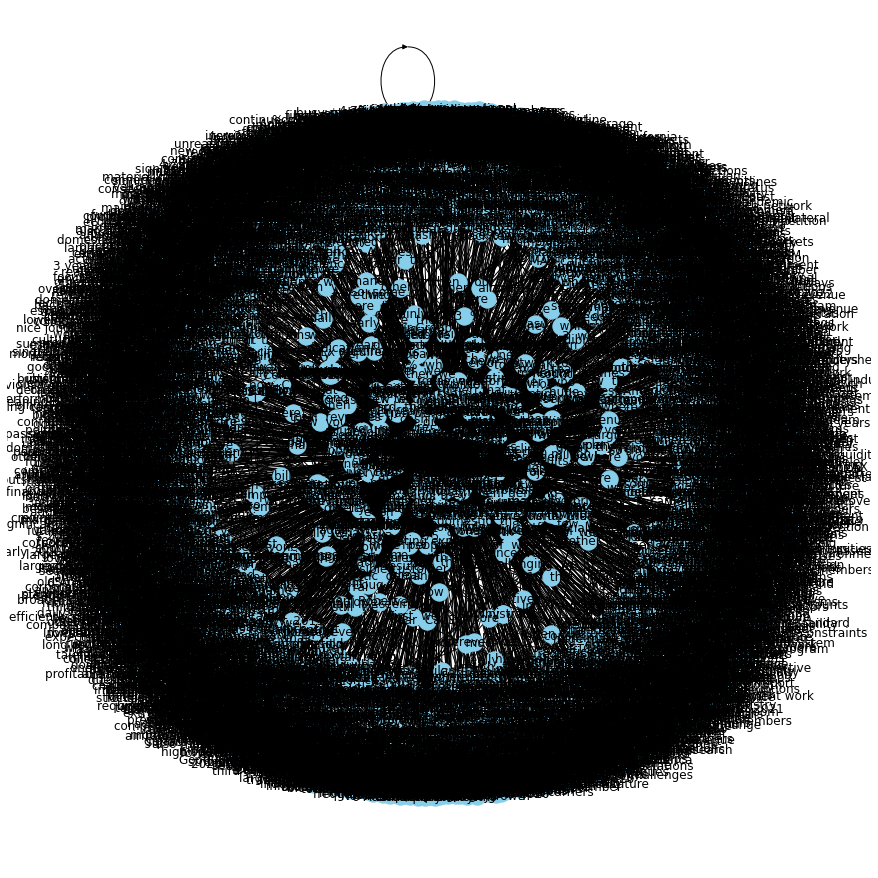

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

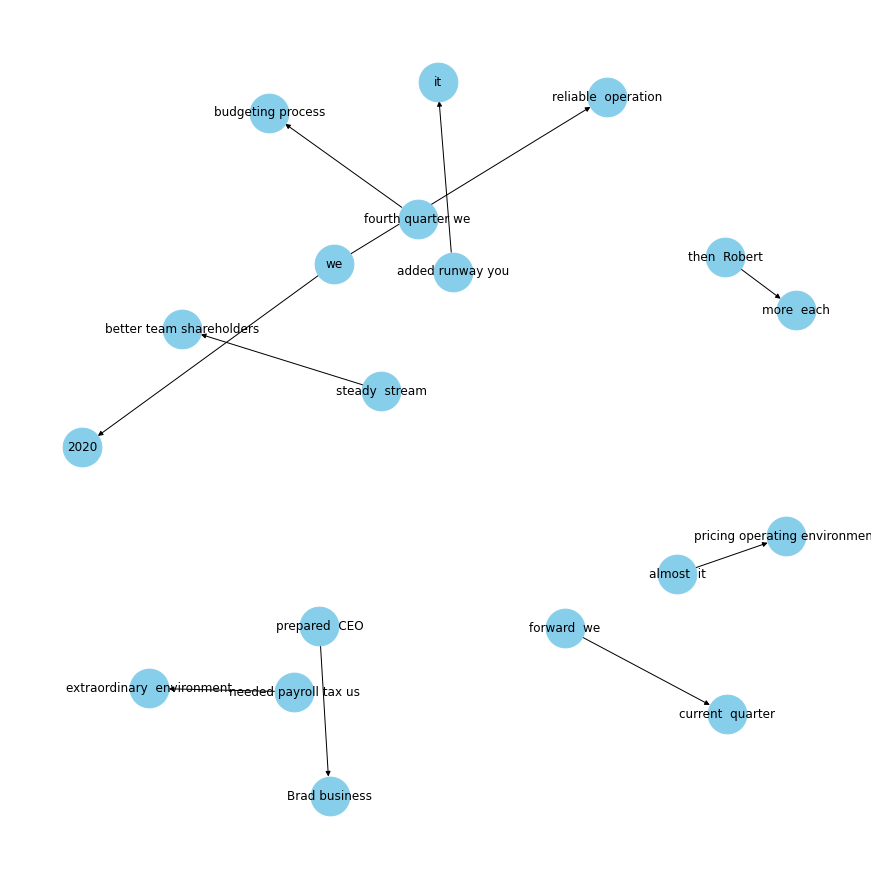

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="provide"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

# Improvements / Variations in Generating Nodes

**Co-reference**

Coreference resolution tries to find all expressions in the text that refer to a specific entity. The below uses the Neuralcoref model from HuggingFace that runs on top of the SpaCy framework.

In [ ]:
!pip install neuralcoref

In [23]:
import spacy
import neuralcoref

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: spacy.morphology.Morphology size changed, may indicate binary incompatibility. Expected 104 from C header, got 112 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: spacy.vocab.Vocab size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: spacy.tokens.span.Span size changed, may indicate binary incompatibility. Expected 72 from C header, got 80 from PyObject
  return f(*args, **kwds)


In [24]:
nlp = spacy.load('en')
neuralcoref.add_to_pipe(nlp)

In [26]:
def coref_resolution(text):

    doc = nlp(text)
    # fetches tokens with whitespaces from spacy document
    tok_list = list(token.text_with_ws for token in doc)
    for cluster in doc._.coref_clusters:
        # get tokens from representative cluster name
        cluster_main_words = set(cluster.main.text.split(' '))
        for coref in cluster:
            if coref != cluster.main:  # if coreference element is not the representative element of that cluster
                if coref.text != cluster.main.text and bool(set(coref.text.split(' ')).intersection(cluster_main_words)) == False:
                    # if coreference element text and representative element text are not equal and none of the coreference element words are in representative element. This was done to handle nested coreference scenarios
                    tok_list[coref.start] = cluster.main.text + \
                        doc[coref.end-1].whitespace_
                    for i in range(coref.start+1, coref.end):
                        tok_list[i] = ""

    return "".join(tok_list)

In [ ]:
data['Transcript_coref'] = data['Transcript_clean'].apply(coref_resolution)

## Functions to Process Spacy Matcher and Dependencies

We create a function for further processing of sentences. The main part is to reduce sentences to a certain length based on distribution of lengths. Potentially also to split and create another sentence. Issue of longer sentences is due to Matcher finding other nouns and/or verbs in other parts of a longer sentence leading to a higher likelihood of irrelevant nouns and verbs paired.

In [39]:
data2

,Date,Sent,Len,Comp
0,2019-04-26,"Good morning, everyone, and welcome to the Am...",16,AAL
1,2019-04-26,With us in the room this morning is Doug Parke...,23,AAL
2,2019-04-26,Also in the room for question and answer sessi...,46,AAL
3,2019-04-26,"Like we normally do, Doug will start the call ...",16,AAL
4,2019-04-26,Derek will then walk us through the details on...,26,AAL
...,...,...,...,...
6893,2019-10-24,"Dan, I my prepared remarks were more aroun...",9,ALK
6894,2019-10-24,And we do not like to get into the details of ...,13,ALK
6895,2019-10-24,But what I will tell you is that this flying h...,26,ALK
6896,2019-10-24,And so we are seeing improved profitability ac...,21,ALK


In [41]:
data2.reset_index(inplace=True)

### Noun-Verb-Noun

In [42]:
row_list = []

for i in range(len(data2)):
    sent = data2.loc[i,'Sent']
    
    if (',' not in sent) and (len(sent.split()) <= 1000):
        
        date = data2.loc[i,'Date']
        comp = data2.loc[i,'Comp']
        length = len(sent.split())
        
        dict1 = {'Date':date,'Sent':sent,'Len':length, 'Comp':comp}
        row_list.append(dict1)
        
# df with shorter sentences
data_out = pd.DataFrame(columns=['Date','Sent','Len','Comp'])
data_out = pd.DataFrame(row_list)

Evaluation function based on hit ratio versus the entire dataset of sentences.

In [24]:
def evaluate(df, out_col):

    result = 0
    for out in df[out_col]:
        if len(out) != 0:
            result += 1
    
    percent = result/len(df)
    percent *= 100
    return percent

Rule to search for verb, then search remaining tokens to the left for the object and searching remaining tokens to the right for the subject. Append to phrase to create three word noun-verb-noun.

In [25]:
def rule_verb(text):
    
    doc = nlp(text)
    sent = []
    for token in doc:
        if (token.pos_=='VERB'):
            phrase = ''
            
            for sub_tok in token.lefts:
                if (sub_tok.dep_ in ['nsubj','nsubjpass']) and (sub_tok.pos_ in ['NOUN','PROPN','PRON']):
                    phrase += sub_tok.text
                    phrase += ' '+token.lemma_ 

                    for sub_tok in token.rights:
                        if (sub_tok.dep_ in ['dobj']) and (sub_tok.pos_ in ['NOUN','PROPN']):
                                    
                            phrase += ' '+sub_tok.text
                            sent.append(phrase)
            
    return sent

In [26]:
row_list = []

for i in range(len(data_out)):
    
    sent = data_out.loc[i,'Sent']
    date = data_out.loc[i,'Date']
    comp = data_out.loc[i,'Comp']

    output = rule_verb(sent)
    dict1 = {'Date':date, 'Sent':sent, 'Output':output, 'Comp':comp}
    row_list.append(dict1)
    
data_nvn = pd.DataFrame(row_list)
evaluate(data_nvn, 'Output')

21.46990740740741

In [27]:
data_result = pd.DataFrame(columns=data_nvn.columns)

for row in range(len(data_nvn)):
    
    if len(data_nvn.loc[row,'Output']) != 0:
        data_result = data_result.append(data_nvn.loc[row,:])

data_result.reset_index(inplace=True)
data_result.drop('index', axis=1, inplace=True)

In [28]:
data_result

,Date,Sent,Output,Comp
0,2019-04-26,Our fleet currently includes 24 Boeing MAX 8 a...,[fleet include aircraft],AAL
1,2019-04-26,We have now removed all 737 MAX flying from ou...,[We remove MAX],AAL
2,2019-04-26,We ended the quarter with approximately $7.2 b...,[We end quarter],AAL
3,2019-04-26,We made contributions of $364 million to our d...,[We make contributions],AAL
4,2019-04-26,Robert will provide more detail on the revenue...,[Robert provide detail],AAL
...,...,...,...,...
366,2019-10-24,We're taking the First Class cabin from 8 to 12,[We take cabin],ALK
367,2019-10-24,And Dan the big thing is we are moving the ai...,[we move airplanes],ALK
368,2019-10-24,We like the fact that people buy out more than...,[We like fact],ALK
369,2019-10-24,In terms of the inning I think we have got a...,[we get quarter],ALK


In [37]:
verb_dict = dict()
dis_dict = dict()
dis_list = []

for i in range(len(data_result)):
    
    sentence = data_result.loc[i,'Sent']
    date = data_result.loc[i,'Date']
    output = data_result.loc[i,'Output']
    comp = data_result.loc[i,'Comp']
    
    for sent in output:
        
        # separate subject, verb and object
        n1, v, n2 = sent.split()[:1], sent.split()[1], sent.split()[2:]

        noun1 = []
        for word in n1:
            if word in ["We", "we", "I"]:
                noun1.append(comp)
            else: noun1.append(word)
        
        # append to list, along with the sentence
        dis_dict = {'Sent':sentence,'Date':date,'Comp':comp,'Noun1':noun1,'Verb':v,'Noun2':n2}
        dis_list.append(dis_dict)
        
        # counting the number of sentences containing the verb
        verb = sent.split()[1]
        if verb in verb_dict:
            verb_dict[verb] += 1
        else:
            verb_dict[verb] = 1

df_final = pd.DataFrame(dis_list)

In [38]:
df_final

,Sent,Date,Comp,Noun1,Verb,Noun2
0,Our fleet currently includes 24 Boeing MAX 8 a...,2019-04-26,AAL,[fleet],include,[aircraft]
1,We have now removed all 737 MAX flying from ou...,2019-04-26,AAL,[AAL],remove,[MAX]
2,We ended the quarter with approximately $7.2 b...,2019-04-26,AAL,[AAL],end,[quarter]
3,We made contributions of $364 million to our d...,2019-04-26,AAL,[AAL],make,[contributions]
4,Robert will provide more detail on the revenue...,2019-04-26,AAL,[Robert],provide,[detail]
...,...,...,...,...,...,...
391,We're taking the First Class cabin from 8 to 12,2019-10-24,ALK,[ALK],take,[cabin]
392,And Dan the big thing is we are moving the ai...,2019-10-24,ALK,[ALK],move,[airplanes]
393,We like the fact that people buy out more than...,2019-10-24,ALK,[ALK],like,[fact]
394,In terms of the inning I think we have got a...,2019-10-24,ALK,[ALK],get,[quarter]


In [62]:
sort = sorted(verb_dict.items(), key = lambda d:(d[1],d[0]), reverse=True)
sort[:10]

[('see', 34),
 ('take', 23),
 ('give', 20),
 ('get', 19),
 ('do', 13),
 ('provide', 11),
 ('make', 10),
 ('end', 9),
 ('add', 9),
 ('have', 8)]

In [39]:
df_final = df_final.drop(['Sent','Date'], axis=1)

In [44]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Comp    396 non-null    object
 1   Noun1   396 non-null    object
 2   Verb    396 non-null    object
 3   Noun2   396 non-null    object
dtypes: object(4)
memory usage: 12.5+ KB


In [50]:
df_final['Noun1'] = df_final['Noun1'].map(lambda x: x[0])
df_final['Noun2'] = df_final['Noun2'].map(lambda x: x[0])

In [51]:
df_final

,Comp,Noun1,Verb,Noun2
0,AAL,fleet,include,aircraft
1,AAL,AAL,remove,MAX
2,AAL,AAL,end,quarter
3,AAL,AAL,make,contributions
4,AAL,Robert,provide,detail
...,...,...,...,...
391,ALK,ALK,take,cabin
392,ALK,ALK,move,airplanes
393,ALK,ALK,like,fact
394,ALK,ALK,get,quarter


### Prepositions

A preposition is a word or group of words used before a noun, pronoun, or noun phrase to show direction, time, place, location, spatial relationships, or to introduce an object. Similar to the previous approach with nouns, we look for prepositions and look at tokens to the left and right for nouns, which the preposition provides the information on the relationship between the two nouns.

In [43]:
def rule_prepositions(text):
  
    doc = nlp(text)
    sent = []
    for token in doc:
        if token.pos_=='ADP':
            phrase = ''
            
            if token.head.pos_=='NOUN':
                
                phrase += token.head.text
                phrase += ' '+token.text

                for right_tok in token.rights:
                    if (right_tok.pos_ in ['NOUN','PROPN']):
                        phrase += ' '+right_tok.text
                
                if len(phrase) > 2:
                    sent.append(phrase)
                
    return sent

In [44]:
row_list = []

for i in range(len(data_out)):
    
    sent = data_out.loc[i,'Sent']
    date = data_out.loc[i,'Date']
    comp = data_out.loc[i,'Comp']

    output = rule_prepositions(sent)
    dict1 = {'Date':date, 'Sent':sent, 'Output':output, 'Comp':comp}
    row_list.append(dict1)
    
data_npn = pd.DataFrame(row_list)
evaluate(data_npn, 'Output')

45.120551090700346

In [45]:
data_npn

,Date,Sent,Output,Comp
0,2019-04-26,Derek will then walk us through the details on...,"[details on quarter, information on guidance, ...",AAL
1,2019-04-26,Robert will then follow with commentary on the...,[commentary on environment],AAL
2,2019-04-26,Work on these aircraft has been completed and ...,[],AAL
3,2019-04-26,Our fleet currently includes 24 Boeing MAX 8 a...,[aircraft with aircraft],AAL
4,2019-04-26,We have now removed all 737 MAX flying from ou...,"[cancellation of flights, flights per day, % o...",AAL
...,...,...,...,...
1737,2019-10-24,But it is still more upside from Saver for a l...,[],ALK
1738,2019-10-24,And we do not like to get into the details of ...,[details of regions],ALK
1739,2019-10-24,But what I will tell you is that this flying h...,[],ALK
1740,2019-10-24,And so we are seeing improved profitability ac...,[result of changes],ALK


In [ ]:
data_npn = data_npn[data_npn["Output"].str.len() != 0]
data_npn.reset_index(inplace=True)
data_npn.drop('index', axis=1, inplace=True)

In [47]:
data_npn

,Date,Sent,Output,Comp
0,2019-04-26,Derek will then walk us through the details on...,"[details on quarter, information on guidance, ...",AAL
1,2019-04-26,Robert will then follow with commentary on the...,[commentary on environment],AAL
2,2019-04-26,Our fleet currently includes 24 Boeing MAX 8 a...,[aircraft with aircraft],AAL
3,2019-04-26,We have now removed all 737 MAX flying from ou...,"[cancellation of flights, flights per day, % o...",AAL
4,2019-04-26,We continue to evaluate financing options for ...,[options for],AAL
...,...,...,...,...
781,2019-10-24,And I think it is anywhere from 1 to 3 extra s...,[seats per aircraft],ALK
782,2019-10-24,In terms of the inning I think we have got a...,[terms of inning],ALK
783,2019-10-24,And it is sort of a tool in the toolkit,[tool in toolkit],ALK
784,2019-10-24,And we do not like to get into the details of ...,[details of regions],ALK


In [57]:
prep_dict = dict()
dis_dict = dict()
dis_list = []

for i in range(len(data_npn)):
    
    sentence = data_npn.loc[i,'Sent']
    date = data_npn.loc[i,'Date']
    output = data_npn.loc[i,'Output']
    comp = data_npn.loc[i,'Comp']
    
    for sent in output:
        
        # separate subject, prep and object
        n1, v, n2 = sent.split()[:1], sent.split()[1], sent.split()[2:]

        noun1 = []
        for word in n1:
            if word in ["We", "we", "I"]:
                noun1.append(comp)
            else: noun1.append(word)
        
        # append to list, along with the sentence
        dis_dict = {'Sent':sentence,'Date':date,'Comp':comp,'Noun1':noun1,'Prep':v,'Noun2':n2}
        dis_list.append(dis_dict)
        
        # counting the number of sentences containing the prep
        prep = sent.split()[1]
        if prep in prep_dict:
            prep_dict[prep] += 1
        else:
            prep_dict[prep] = 1

df_final2 = pd.DataFrame(dis_list)

In [58]:
df_final2

,Sent,Date,Comp,Noun1,Prep,Noun2
0,Derek will then walk us through the details on...,2019-04-26,AAL,[details],on,[quarter]
1,Derek will then walk us through the details on...,2019-04-26,AAL,[information],on,[guidance]
2,Derek will then walk us through the details on...,2019-04-26,AAL,[guidance],for,[remainder]
3,Derek will then walk us through the details on...,2019-04-26,AAL,[remainder],of,[year]
4,Robert will then follow with commentary on the...,2019-04-26,AAL,[commentary],on,[environment]
...,...,...,...,...,...,...
1103,And I think it is anywhere from 1 to 3 extra s...,2019-10-24,ALK,[seats],per,[aircraft]
1104,In terms of the inning I think we have got a...,2019-10-24,ALK,[terms],of,[inning]
1105,And it is sort of a tool in the toolkit,2019-10-24,ALK,[tool],in,[toolkit]
1106,And we do not like to get into the details of ...,2019-10-24,ALK,[details],of,[regions]


In [60]:
df_final2 = df_final2.drop(['Sent','Date'], axis=1)

In [61]:
df_final2 = df_final2[df_final2["Noun2"].str.len() != 0]

In [64]:
df_final2['Noun1'] = df_final2['Noun1'].map(lambda x: x[0])
df_final2['Noun2'] = df_final2['Noun2'].map(lambda x: x[0])

## Network Graph Plots

In [52]:
# Grouby and creat weights if applicable
kg_df = df_final.groupby(df_final.columns.tolist(),as_index=False).size()

In [68]:
import networkx as nx

In [67]:
list = ['AAL', 'ALK']

In [77]:
graphs = [nx.from_pandas_edgelist(df_final[df_final['Comp'] == i], "Noun1", "Noun2", edge_attr="Verb",
                                  create_using=nx.MultiDiGraph()) for i in list]

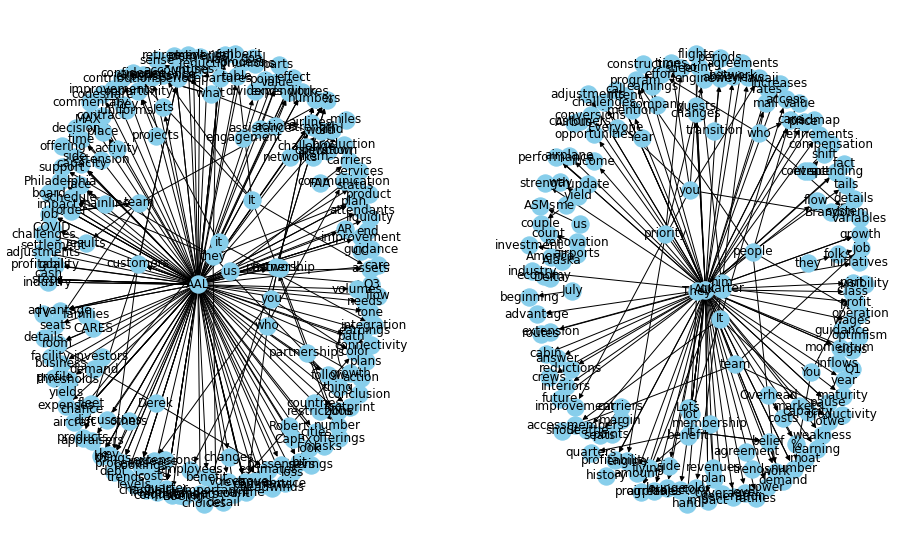

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,10))
ax = axes.flatten()

for x in range(2):
      # size = [i['size'] for i in dict(graphs[x].edges).values()]
      pos = nx.spring_layout(graphs[x])
      labels = [i for i in dict(graphs[x].nodes).keys()]
      labels = {i:i for i in dict(graphs[x].nodes).keys()}
      nx.draw_networkx_nodes(graphs[x], pos, label=True, node_color='skyblue', ax=ax[x])
      nx.draw_networkx_edges(graphs[x], pos, edge_cmap=plt.cm.Blues, ax=ax[x]) # width=size
      _ = nx.draw_networkx_labels(graphs[x], pos, labels, ax=ax[x])
      ax[x].set_axis_off()

plt.show()

In [82]:
graphs = [nx.from_pandas_edgelist(df_final[df_final['Verb'] == "provide"], "Noun1", "Noun2", edge_attr="Verb",
                                  create_using=nx.MultiDiGraph()) for i in list]

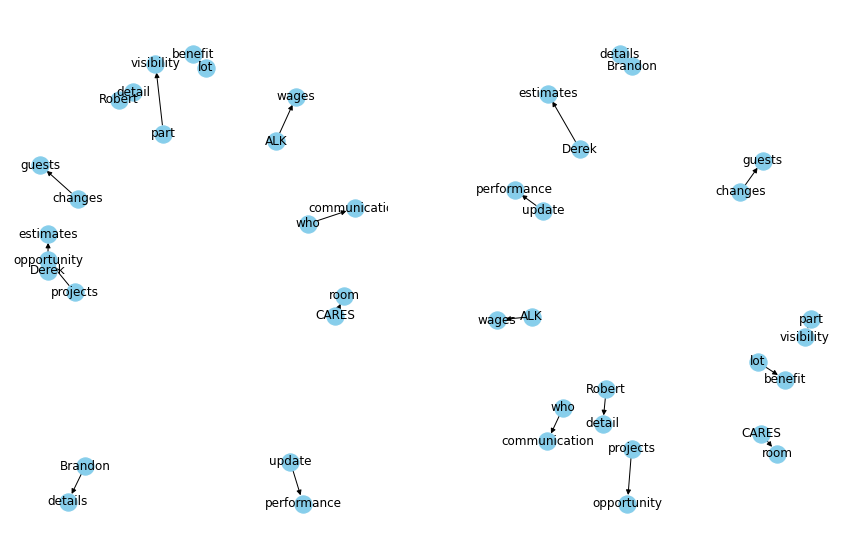

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax = axes.flatten()

for x in range(2):
      # size = [i['size'] for i in dict(graphs[x].edges).values()]
      pos = nx.spring_layout(graphs[x])
      labels = [i for i in dict(graphs[x].nodes).keys()]
      labels = {i:i for i in dict(graphs[x].nodes).keys()}
      nx.draw_networkx_nodes(graphs[x], pos, label=True, node_color='skyblue', ax=ax[x])
      nx.draw_networkx_edges(graphs[x], pos, edge_cmap=plt.cm.Blues, ax=ax[x]) # width=size
      _ = nx.draw_networkx_labels(graphs[x], pos, labels, ax=ax[x])
      ax[x].set_axis_off()

plt.show()

In [65]:
kg_df2 = df_final2.groupby(df_final.columns.tolist(),as_index=False).size()

In [69]:
graphs2 = [nx.from_pandas_edgelist(df_final2[df_final2['Comp'] == i], "Noun1", "Noun2", edge_attr="Prep",
                                  create_using=nx.MultiDiGraph()) for i in list]

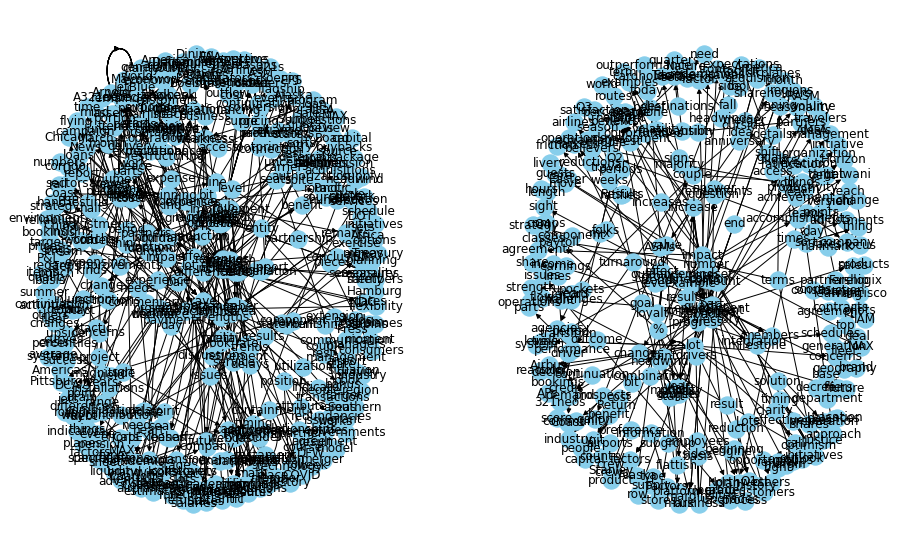

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,10))
ax = axes.flatten()

for x in range(2):
      # size = [i['size'] for i in dict(graphs2[x].edges).values()]
      pos = nx.spring_layout(graphs2[x])
      labels = [i for i in dict(graphs2[x].nodes).keys()]
      labels = {i:i for i in dict(graphs2[x].nodes).keys()}
      nx.draw_networkx_nodes(graphs2[x], pos, label=True, node_color='skyblue', ax=ax[x])
      nx.draw_networkx_edges(graphs2[x], pos, edge_cmap=plt.cm.Blues, ax=ax[x]) # width=size
      _ = nx.draw_networkx_labels(graphs2[x], pos, labels, ax=ax[x])
      ax[x].set_axis_off()

plt.show()

# Additional Tools

Wikifier - Semantic Annotation Service, detects entities and returns classes that an entity belongs to. It looks at the INSTANCE_OF and SUBCLASS_OF classes and traverses all the way through the class hierarchy. Therefore, further filtered for person, organization and location.

In [ ]:
import urllib
from string import punctuation
import nltk

In [ ]:
ENTITY_TYPES = ["human", "person", "company", "enterprise", "business", "geographic region",
                "human settlement", "geographic entity", "territorial entity type", "organization"]

In [ ]:
def wikifier(text, lang="en", threshold=0.8):

    data = urllib.parse.urlencode([
        ("text", text), ("lang", lang),
        ("userKey", "asgdpddcuqiqkcleikwlgsfdskdaws"),
        ("pageRankSqThreshold", "%g" %
         threshold), ("applyPageRankSqThreshold", "true"),
        ("nTopDfValuesToIgnore", "90"), ("nWordsToIgnoreFromList", "90"),
        ("wikiDataClasses", "true"), ("wikiDataClassIds", "false"),
        ("support", "true"), ("ranges", "false"), ("minLinkFrequency", "2"),
        ("includeCosines", "false"), ("maxMentionEntropy", "3")
    ])
    url = "http://www.wikifier.org/annotate-article"

    req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
    with urllib.request.urlopen(req, timeout=60) as f:
        response = f.read()
        response = json.loads(response.decode("utf8"))
    # Output the annotations.
    results = list()
    for annotation in response["annotations"]:
        # Filter out desired entity classes
        if ('wikiDataClasses' in annotation) and (any([el['enLabel'] in ENTITY_TYPES for el in annotation['wikiDataClasses']])):

            # Specify entity label
            if any([el['enLabel'] in ["human", "person"] for el in annotation['wikiDataClasses']]):
                label = 'Person'
            elif any([el['enLabel'] in ["company", "enterprise", "business", "organization"] for el in annotation['wikiDataClasses']]):
                label = 'Organization'
            elif any([el['enLabel'] in ["geographic region", "human settlement", "geographic entity", "territorial entity type"] for el in annotation['wikiDataClasses']]):
                label = 'Location'
            else:
                label = None

            results.append({'title': annotation['title'], 'wikiId': annotation['wikiDataItemId'], 'label': label,
                            'characters': [(el['chFrom'], el['chTo']) for el in annotation['support']]})
    return results

In [ ]:
entities = wikifier(sentence, threshold=entities_threshold)
# Iterate over every permutation pair of entities
for permutation in itertools.permutations(entities, 2):
    for source in permutation[0]['characters']:
        for target in permutation[1]['characters']:
            # Relationship extraction with OpenNRE
            data = relation_model.infer(
                {'text': sentence, 'h': {'pos': [source[0], source[1] + 1]}, 't': {'pos': [target[0], target[1] + 1]}})
            if data[1] > relation_threshold:
                relations_list.append(
                    {'source': permutation[0]['title'], 'target': permutation[1]['title'], 'type': data[0]})